In [1]:
import pandas as pd
!mkdir -p /content/house-prices
!unzip -o "/content/house-prices-advanced-regression-techniques.zip" -d /content/house-prices > /dev/null



In [2]:
!pip install -q pandas numpy scikit-learn joblib

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


In [3]:
train = pd.read_csv("/content/house-prices/train.csv")
test = pd.read_csv("/content/house-prices/test.csv")

train.shape, test.shape, train.columns[:5]


((1460, 81),
 (1459, 80),
 Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea'], dtype='object'))

In [4]:
y = np.log1p(train["SalePrice"])
X = train.drop(columns=["SalePrice"])


In [5]:
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

numeric = SimpleImputer(strategy="median")
categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric, num_cols),
    ("cat", categorical, cat_cols)
])


In [6]:
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

pipe = Pipeline([
    ("prep", preprocess),
    ("rf", model)
])

scores = -1 * cross_val_score(pipe, X, y, cv=5, scoring="neg_root_mean_squared_error")
print(f"CV Log RMSE: {scores.mean():.4f} ± {scores.std():.4f}")


CV Log RMSE: 0.1426 ± 0.0096


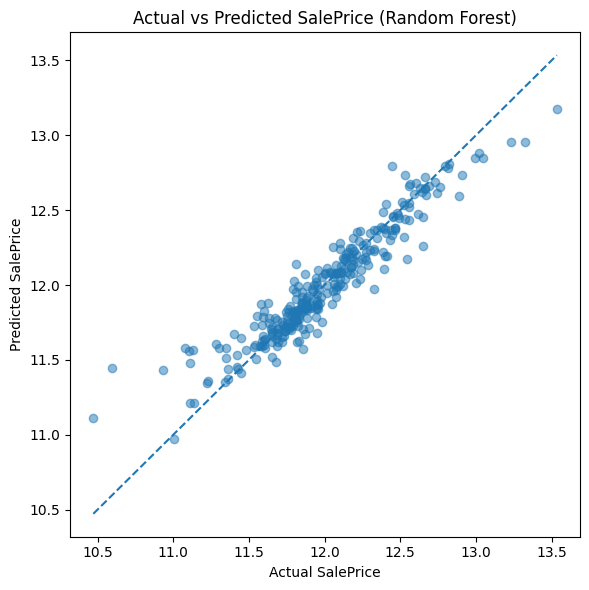

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# If you haven't already split:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the pipeline on the training set
pipe.fit(X_train, y_train)

# Predict on the test set
y_pred = pipe.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")  # 45° reference line

plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice (Random Forest)")
plt.tight_layout()
plt.show()
